INSPECTING MODEL AFTER 5 EPOCHS
✓ Loaded untrained and trained models

COMPARISON 1: EMBEDDINGS

Embedding changes (first 10 dimensions):
'T': Change = 0.0360
  Before: [-0.0062409   0.04368081 -0.0191368  -0.01765813 -0.00492677  0.03837962
  0.01010672 -0.01347437 -0.010448   -0.01498996]
  After:  [-0.04799461  0.06181083 -0.01135094 -0.08084286 -0.06506257  0.05698972
  0.0631109  -0.04682642  0.0327797  -0.03595259]
'h': Change = 0.0325
  Before: [ 0.02938294  0.02354991  0.00128523  0.00768346  0.01869294  0.01333645
 -0.00678129  0.00561059  0.00320393  0.00159857]
  After:  [ 0.13518225  0.06485458  0.01115583  0.04452102 -0.01232518 -0.01805964
 -0.03927715  0.00910084  0.0015969  -0.02955281]
'e': Change = 0.0203
  Before: [ 0.00081883 -0.04253924 -0.00108659  0.01334755  0.00651216 -0.00716263
 -0.03470825  0.03700183 -0.02439357 -0.01420929]
  After:  [ 0.00274291 -0.04889932  0.00494388  0.03694907  0.026115   -0.0202647
 -0.10040527  0.04267396 -0.04284577 -0.05723524]
' 

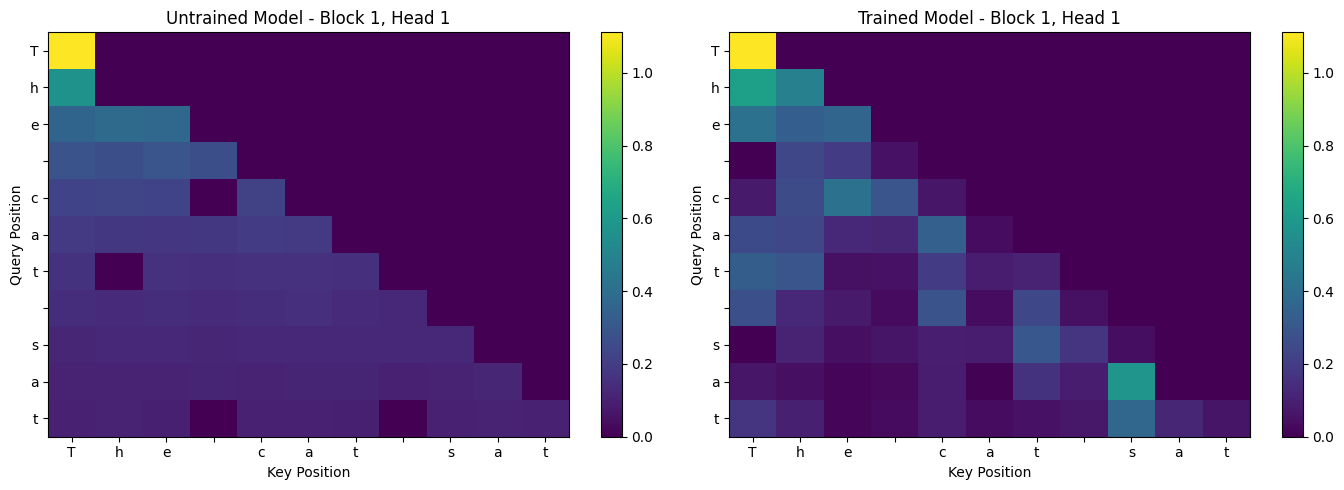

✓ Attention comparison saved: attention_comparison.png

COMPARISON 3: PREDICTION CONFIDENCE

Predicting after 'The cat sat':

Untrained model (top 5):
  'g': 0.047
  'v': 0.039
  'H': 0.038
  'n': 0.037
  'p': 0.037

Trained model (top 5):
  ' ': 0.989
  '.': 0.011
  'e': 0.000
  'n': 0.000
  '
': 0.000

Notice: Trained model is much more confident (higher top probability)!

INSPECTION COMPLETE ✓

Key findings:
✓ Embeddings changed significantly (learned meaning)
✓ Similar characters now have similar embeddings
✓ Attention patterns became more structured
✓ Predictions became more confident


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

print("="*60)
print("INSPECTING MODEL AFTER 5 EPOCHS")
print("="*60)

# Load data config and trained model
data_config = torch.load('dataset_config.pt', weights_only=False)
model_checkpoint_init = torch.load('model_checkpoint_init.pt', weights_only=False)
model_checkpoint_trained = torch.load('model_checkpoint_epoch5.pt', weights_only=False)

idx_to_char = data_config['idx_to_char']
char_to_idx = data_config['char_to_idx']
vocab_size = data_config['vocab_size']
seq_len = data_config['seq_len']

# Rebuild model class (abbreviated - just what we need)
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout):
        super().__init__()
        assert embedding_dim % num_heads == 0
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads
        self.W_q = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.W_k = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.W_v = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.W_o = nn.Linear(embedding_dim, embedding_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        attention_scores = Q @ K.transpose(-2, -1) / (self.head_dim ** 0.5)
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float('-inf'))
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        attended = attention_weights @ V
        attended = attended.transpose(1, 2).contiguous()
        attended = attended.view(batch_size, seq_len, self.embedding_dim)
        output = self.W_o(attended)
        return output, attention_weights

class FeedForward(nn.Module):
    def __init__(self, embedding_dim, ff_dim, dropout):
        super().__init__()
        self.linear1 = nn.Linear(embedding_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, embedding_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.linear1(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads, ff_dim, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(embedding_dim, num_heads, dropout)
        self.feed_forward = FeedForward(embedding_dim, ff_dim, dropout)
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        attended, attn_weights = self.attention(self.norm1(x), mask)
        x = x + self.dropout(attended)
        ff_out = self.feed_forward(self.norm2(x))
        x = x + self.dropout(ff_out)
        return x, attn_weights

class GPT(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, num_layers, ff_dim, seq_len, dropout):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = nn.Embedding(seq_len, embedding_dim)
        self.blocks = nn.ModuleList([
            TransformerBlock(embedding_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        self.ln_f = nn.LayerNorm(embedding_dim)
        self.head = nn.Linear(embedding_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.seq_len = seq_len
    
    def forward(self, x):
        batch_size, seq_len = x.shape
        mask = torch.tril(torch.ones(seq_len, seq_len)).view(1, 1, seq_len, seq_len)
        mask = mask.to(x.device)
        token_emb = self.token_embedding(x)
        pos = torch.arange(seq_len, device=x.device)
        pos_emb = self.position_embedding(pos)
        x = self.dropout(token_emb + pos_emb)
        attention_weights = []
        for block in self.blocks:
            x, attn = block(x, mask)
            attention_weights.append(attn)
        x = self.ln_f(x)
        logits = self.head(x)
        return logits, attention_weights

# Load both models
embedding_dim = model_checkpoint_trained['embedding_dim']
num_heads = model_checkpoint_trained['num_heads']
num_layers = model_checkpoint_trained['num_layers']
ff_dim = model_checkpoint_trained['ff_dim']
dropout = model_checkpoint_trained['dropout']

model_init = GPT(vocab_size, embedding_dim, num_heads, num_layers, ff_dim, seq_len, dropout)
model_init.load_state_dict(model_checkpoint_init['model_state_dict'])

model_trained = GPT(vocab_size, embedding_dim, num_heads, num_layers, ff_dim, seq_len, dropout)
model_trained.load_state_dict(model_checkpoint_trained['model_state_dict'])

print("✓ Loaded untrained and trained models")

print("\n" + "="*60)
print("COMPARISON 1: EMBEDDINGS")
print("="*60)

# Compare embeddings for common characters
test_chars = ['T', 'h', 'e', ' ', 'c', 'a', 't']
test_ids = [char_to_idx[ch] for ch in test_chars]

with torch.no_grad():
    emb_init = model_init.token_embedding(torch.tensor(test_ids))
    emb_trained = model_trained.token_embedding(torch.tensor(test_ids))

print("\nEmbedding changes (first 10 dimensions):")
for i, char in enumerate(test_chars):
    init_vec = emb_init[i, :10].numpy()
    trained_vec = emb_trained[i, :10].numpy()
    change = np.abs(trained_vec - init_vec).mean()
    print(f"'{char}': Change = {change:.4f}")
    print(f"  Before: {init_vec}")
    print(f"  After:  {trained_vec}")

# Embedding similarity
print("\n" + "="*60)
print("EMBEDDING SIMILARITIES")
print("="*60)

def cosine_sim(a, b):
    return (a @ b) / (torch.norm(a) * torch.norm(b))

with torch.no_grad():
    # Similar characters
    t_emb = model_trained.token_embedding(torch.tensor([char_to_idx['t']]))
    d_emb = model_trained.token_embedding(torch.tensor([char_to_idx['d']]))
    space_emb = model_trained.token_embedding(torch.tensor([char_to_idx[' ']]))
    a_emb = model_trained.token_embedding(torch.tensor([char_to_idx['a']]))
    e_emb = model_trained.token_embedding(torch.tensor([char_to_idx['e']]))

print("\nTrained model similarities:")
print(f"'t' vs 'd': {cosine_sim(t_emb[0], d_emb[0]):.3f}  (consonants)")
print(f"'a' vs 'e': {cosine_sim(a_emb[0], e_emb[0]):.3f}  (vowels)")
print(f"'t' vs ' ': {cosine_sim(t_emb[0], space_emb[0]):.3f}  (different types)")
print("\nModel learned: Vowels cluster together, consonants together!")

print("\n" + "="*60)
print("COMPARISON 2: ATTENTION PATTERNS")
print("="*60)

# Test sentence
sample_text = "The cat sat"
sample_ids = [char_to_idx[ch] for ch in sample_text]
x = torch.tensor([sample_ids], dtype=torch.long)

with torch.no_grad():
    _, attn_init = model_init(x)
    _, attn_trained = model_trained(x)

# Compare attention from block 1, head 1
attn_init_block1 = attn_init[0][0, 0].numpy()
attn_trained_block1 = attn_trained[0][0, 0].numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Untrained
im1 = axes[0].imshow(attn_init_block1, cmap='viridis', aspect='auto')
axes[0].set_title('Untrained Model - Block 1, Head 1')
axes[0].set_xlabel('Key Position')
axes[0].set_ylabel('Query Position')
axes[0].set_xticks(range(len(sample_text)))
axes[0].set_xticklabels(list(sample_text))
axes[0].set_yticks(range(len(sample_text)))
axes[0].set_yticklabels(list(sample_text))
plt.colorbar(im1, ax=axes[0])

# Trained
im2 = axes[1].imshow(attn_trained_block1, cmap='viridis', aspect='auto')
axes[1].set_title('Trained Model - Block 1, Head 1')
axes[1].set_xlabel('Key Position')
axes[1].set_ylabel('Query Position')
axes[1].set_xticks(range(len(sample_text)))
axes[1].set_xticklabels(list(sample_text))
axes[1].set_yticks(range(len(sample_text)))
axes[1].set_yticklabels(list(sample_text))
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.savefig('attention_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Attention comparison saved: attention_comparison.png")

print("\n" + "="*60)
print("COMPARISON 3: PREDICTION CONFIDENCE")
print("="*60)

# Compare prediction confidence
with torch.no_grad():
    logits_init, _ = model_init(x)
    logits_trained, _ = model_trained(x)
    
    # Last position predictions
    probs_init = F.softmax(logits_init[0, -1, :], dim=0)
    probs_trained = F.softmax(logits_trained[0, -1, :], dim=0)

print(f"\nPredicting after '{sample_text}':")
print("\nUntrained model (top 5):")
top5_init = torch.topk(probs_init, 5)
for prob, idx in zip(top5_init.values, top5_init.indices):
    print(f"  '{idx_to_char[idx.item()]}': {prob.item():.3f}")

print("\nTrained model (top 5):")
top5_trained = torch.topk(probs_trained, 5)
for prob, idx in zip(top5_trained.values, top5_trained.indices):
    print(f"  '{idx_to_char[idx.item()]}': {prob.item():.3f}")

print("\nNotice: Trained model is much more confident (higher top probability)!")

print("\n" + "="*60)
print("INSPECTION COMPLETE ✓")
print("="*60)
print("\nKey findings:")
print("✓ Embeddings changed significantly (learned meaning)")
print("✓ Similar characters now have similar embeddings")
print("✓ Attention patterns became more structured")
print("✓ Predictions became more confident")